In [2]:
import pandas as pd
import numpy as np
import os

# Set up a map to make labels human-readable.
label_map = {
  1: 'walking',
  2: 'running',
  3: 'shuffling',
  4: 'stairs (ascending)',
  5: 'stairs (descending)',
  6: 'standing',
  7: 'sitting',
  8: 'lying',
  9: 'stairs',
  13: 'cycling (sit)',
  14: 'cycling (stand)',
  130: 'cycling (sit, inactive)',
  140: 'cycling (stand, inactive)'
}

features = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']

# Generate a pandas dataframe for a given filename.
# Parse timestamp column as a datetime type.
def read_file(name):
    df = pd.read_csv(name, index_col=['timestamp'], parse_dates=['timestamp'])
    df['file'] = os.path.splitext(os.path.basename(name))[0]
    return df

filepaths = ['./MLT-CW-Dataset/'+f for f in os.listdir('./MLT-CW-Dataset') if f.endswith('.csv')]
df = pd.concat(map(read_file, filepaths))
df.drop(labels = ['index', 'Unnamed: 0'], axis = 'columns', inplace = True)

# Sanity check for data loaded.
print(df.head(2))
print(f'Index name: {df.index.name}, index datatype: {df.index.dtype}')
print(f'Columns: {df.columns}') 


                           back_x    back_y    back_z   thigh_x   thigh_y  \
timestamp                                                                   
2019-01-12 00:00:00.000 -0.982201 -0.031251  0.178300 -0.935149  0.006160   
2019-01-12 00:00:00.020 -0.973421 -0.042747  0.190618 -0.934986  0.040489   

                          thigh_z  label  file  
timestamp                                       
2019-01-12 00:00:00.000 -0.358898      6  S016  
2019-01-12 00:00:00.020 -0.366376      6  S016  
Index name: timestamp, index datatype: datetime64[ns]
Columns: Index(['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z', 'label',
       'file'],
      dtype='object')


In [3]:
from py_markdown_table import markdown_table as mt

suspect_sensor = 'S007'

focus_sensor = df[df['file'] == suspect_sensor]
other_sensor = df[df['file'] != suspect_sensor]

features = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
for feature in features:
    print(f'## Sensor ID: {suspect_sensor}, Feature: {feature}')
    print_data = [
        {
            'Measurement': 'Not null Count',
            'For Sensor ' + suspect_sensor: focus_sensor[feature].count(),
            'For Others': other_sensor[feature].count()
        },
        {
            'Measurement': 'Mean',
            'For Sensor ' + suspect_sensor: focus_sensor[feature].mean(),
            'For Others': other_sensor[feature].mean()
        },
        {
            'Measurement': 'Variance',
            'For Sensor ' + suspect_sensor: focus_sensor[feature].var(),
            'For Others': other_sensor[feature].var()
        },
        {
            'Measurement': 'Maximum',
            'For Sensor ' + suspect_sensor: focus_sensor[feature].max(),
            'For Others': other_sensor[feature].max()
        },
        {
            'Measurement': 'Minimum',
            'For Sensor ' + suspect_sensor: focus_sensor[feature].min(),
            'For Others': other_sensor[feature].min()
        }
    ]
    print(mt.markdown_table(print_data).set_params(float_rounding=2, padding_weight='left').get_markdown())


## Sensor ID: S007, Feature: back_x
```
+--------------+---------------+----------+
|   Measurement|For Sensor S007|For Others|
+--------------+---------------+----------+
|Not null Count|         408709|   5160237|
+--------------+---------------+----------+
|          Mean|          -0.72|     -0.88|
+--------------+---------------+----------+
|      Variance|           0.19|      0.14|
+--------------+---------------+----------+
|       Maximum|            1.6|      2.29|
+--------------+---------------+----------+
|       Minimum|         -66.54|     -5.77|
+--------------+---------------+----------+```
## Sensor ID: S007, Feature: back_y
```
+--------------+---------------+----------+
|   Measurement|For Sensor S007|For Others|
+--------------+---------------+----------+
|Not null Count|         408709|   5160237|
+--------------+---------------+----------+
|          Mean|           0.02|     -0.02|
+--------------+---------------+----------+
|      Variance|           0.07|     

In [4]:
# Write a function to drop data labelled with any type of cycling, the company
# is not currently interested in them. Apply it to the dataset and report the new
# dataset size.
def drop_labelled_rows(df, labels, inplace):
    return df.drop(df[df['label'].isin(labels)].index, inplace = inplace)

# Note that data with the label 10 has also been filtered out, since label 10 doesn't correspond with any known activity.
print(f'Number of dataframe rows before removing cycling: {len(df)}')
drop_labelled_rows(df, [10, 13, 14, 130, 140], True)
print(f'Number of dataframe rows after removing cycling: {len(df)}')

Number of dataframe rows before removing cycling: 5568946
Number of dataframe rows after removing cycling: 3131039


In [5]:
# Write a function to merge the stairs (ascending) and stairs (descending) labels
# in a single class “stairs” with code 9, as the company wants to consider them
# as a single action. Apply it to the dataset
def merge_values(df, column, merge_values, inplace):
    return df.replace(to_replace={column: merge_values}, inplace = inplace)

merge_values(df, 'label', {4:9, 5:9}, True)

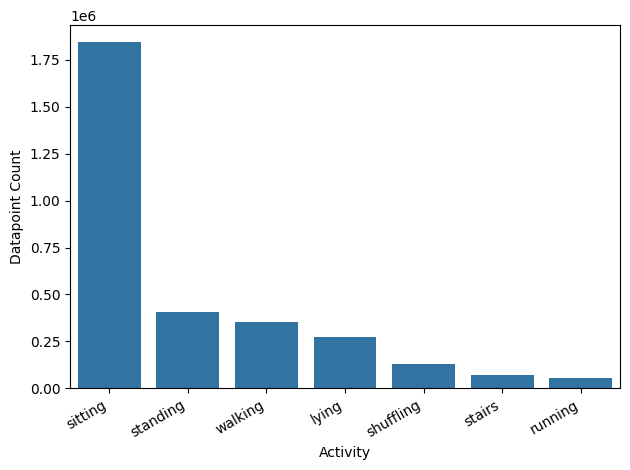

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Report the class balance of the whole dataset.
value_counts = df['label'].value_counts()

# Plot the frequency distribution by label.
ax = sns.countplot(df, x='label', order = value_counts.index)
ax.set_xticks(list(range(0, value_counts.size)))
new_labels = [label_map.get(int(label.get_text())) for label in ax.get_xticklabels()]
ax.set_xticklabels(new_labels)
ax.set_xlabel('Activity')
ax.set_ylabel('Datapoint Count')
# Rotate long x axis labels. Same as , rotation=45, ha='right'
ax.figure.autofmt_xdate()
plt.tight_layout()
plt.show()

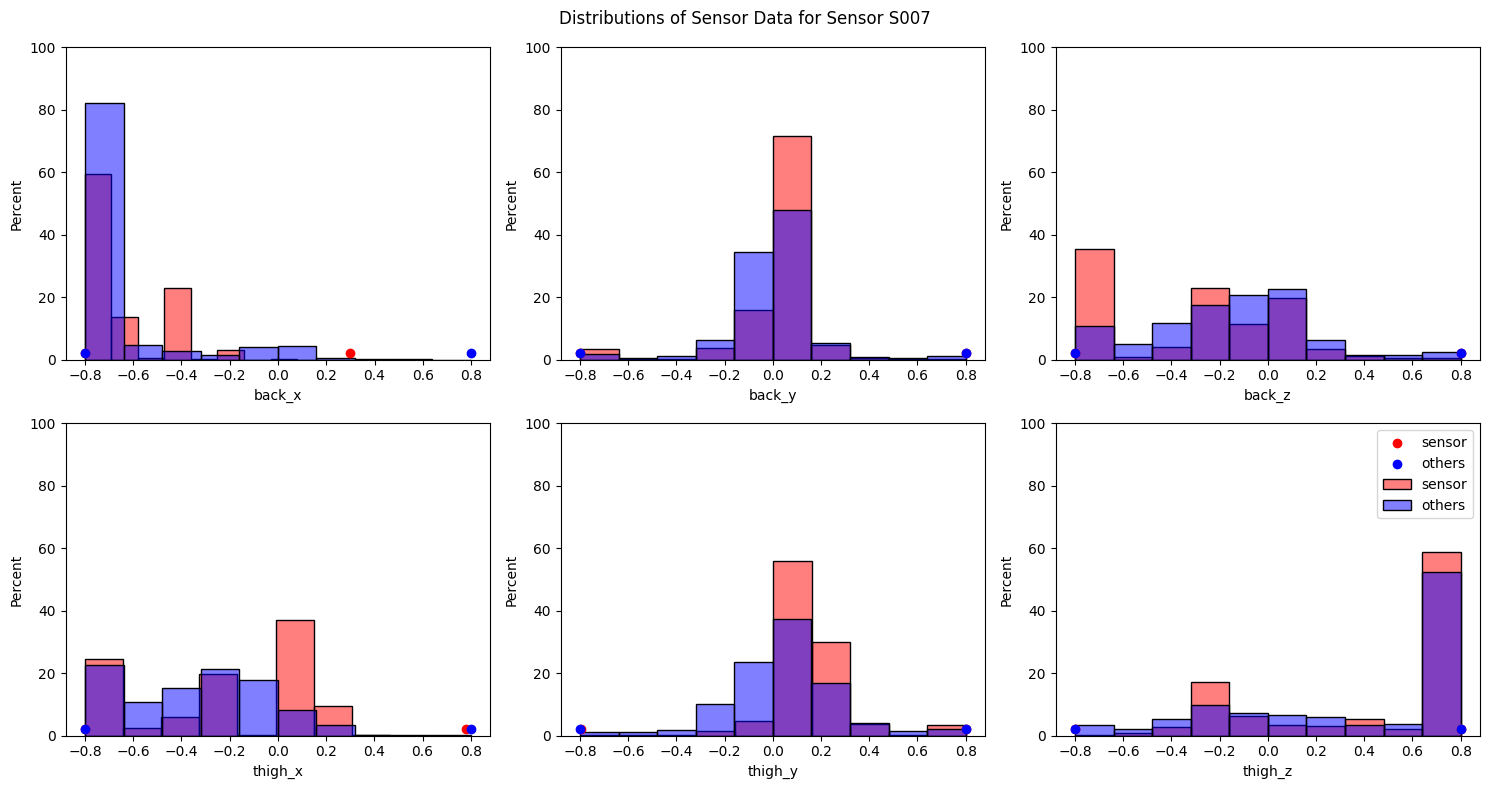

In [9]:
# When performing a t-test on time series data from two sensors, where one sensor is suspected faulty, it is generally 
# safer not to assume that the variances are equal. Perform Welch’s t-test, which does not assume equal population variance.
# res = ttest_ind(sample_x, other_x, equal_var=False)
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle(f'Distributions of Sensor Data for Sensor {suspect_sensor}')
for i, ax in enumerate(axs.flatten()):
    ax.set_ylim(0, 100)
    sns.histplot(data=focus_sensor[features[i]], log_scale=False, bins=10, stat='percent', color='red', alpha=0.5, label='sensor', ax=ax)
    hist = sns.histplot(data=other_sensor[features[i]], log_scale=False, bins=10, stat='percent', color='blue', alpha=0.5, label='others', ax=ax)
    ax.scatter(x=focus_sensor[features[i]].min(), y=2, color='red')
    ax.scatter(x=focus_sensor[features[i]].max(), y=2, color='red', label='sensor')
    ax.scatter(x=other_sensor[features[i]].min(), y=2, color='blue')
    ax.scatter(x=other_sensor[features[i]].max(), y=2, color='blue', label='others')
# handles1, labels1 = hist.get_legend_handles_labels()
hist.legend()
plt.tight_layout()
plt.show()

In [6]:
back_x_max = df[df['file'] == 'S007']['back_x'].abs().idxmax()
rows_containing_max = df.loc[back_x_max - pd.Timedelta(milliseconds=10): back_x_max + pd.Timedelta(milliseconds=10)].reset_index().to_dict(orient='records')
print(mt.markdown_table(rows_containing_max).set_params(float_rounding=2, padding_weight='left').get_markdown())

```
+--------------------------+------+------+------+-------+-------+-------+-----+----+
|                 timestamp|back_x|back_y|back_z|thigh_x|thigh_y|thigh_z|label|file|
+--------------------------+------+------+------+-------+-------+-------+-----+----+
|2019-01-17 00:47:28.170000| -0.67|  0.02| -0.69|   0.13|   0.22|   0.92|    7|S007|
+--------------------------+------+------+------+-------+-------+-------+-----+----+
|2019-01-17 00:47:28.180000|-66.54|  0.02| -0.68|   0.13|   0.22|   0.92|    7|S007|
+--------------------------+------+------+------+-------+-------+-------+-----+----+
|2019-01-17 00:47:28.190000| -0.67|  0.02| -0.68|   0.13|   0.22|   0.92|    7|S007|
+--------------------------+------+------+------+-------+-------+-------+-----+----+```


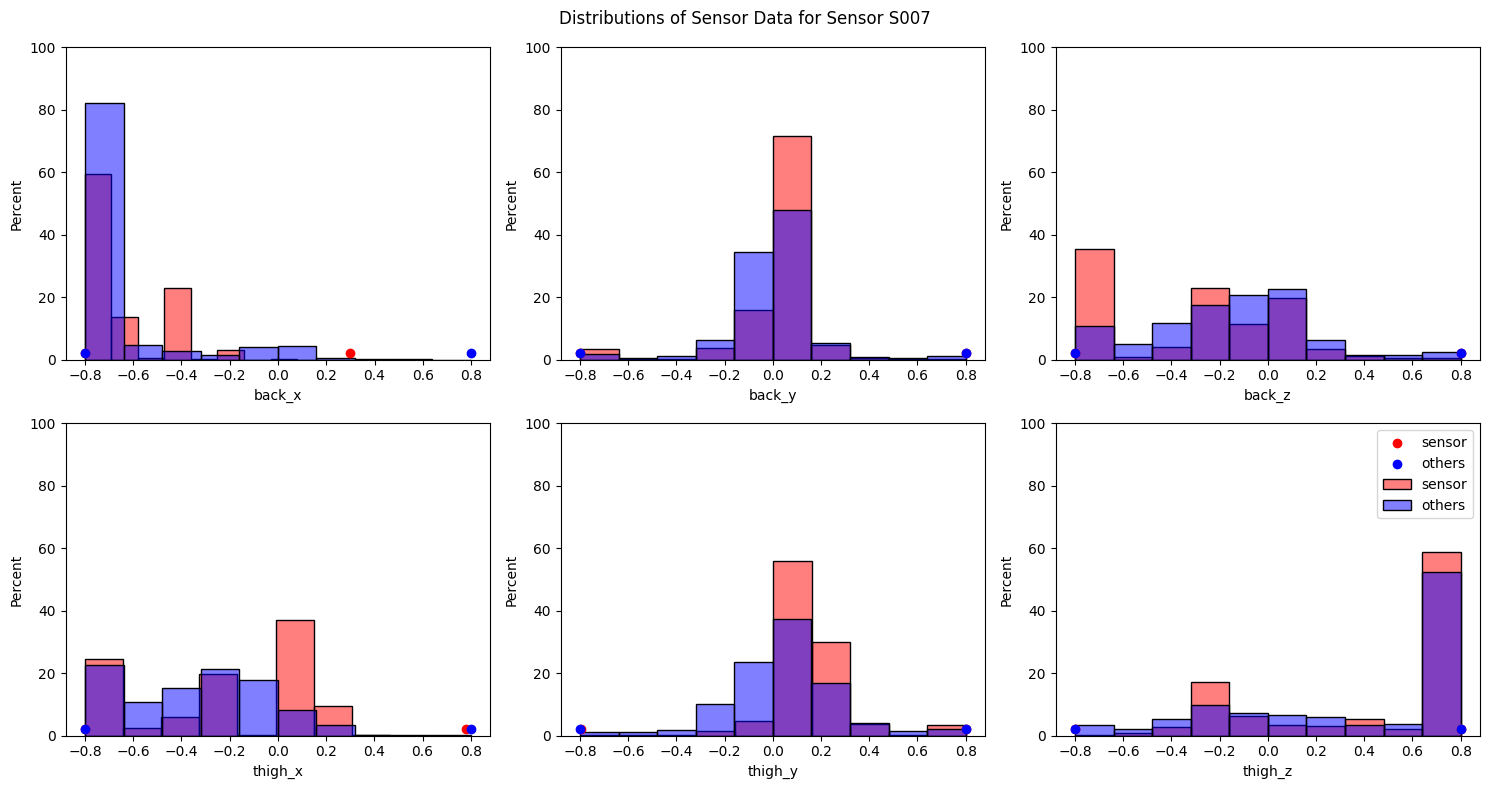

In [10]:
# The Axivity AX3 can measure up to 16g, so clearly -66g is erroneous. We'll assume a maximum ±8 g for running (the most vigourous activity in the study)
# for all sensors, and reset values above that by interpolation.
THRESHOLD = .8
outliers = df.loc[:, features].abs() > THRESHOLD
clean_data = df.loc[:, features].mask(outliers, np.nan)
clean_data = clean_data.interpolate(method='linear').ffill().bfill()

clean_df = df.copy()
clean_df.loc[:, features] = clean_data

focus_sensor = clean_df[clean_df['file'] == suspect_sensor]
other_sensor = clean_df[clean_df['file'] != suspect_sensor]

fig, axs = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle(f'Distributions of Sensor Data for Sensor {suspect_sensor}')
for i, ax in enumerate(axs.flatten()):
    ax.set_ylim(0, 100)
    sns.histplot(data=focus_sensor[features[i]], log_scale=False, bins=10, stat='percent', color='red', alpha=0.5, label='sensor', ax=ax)
    hist = sns.histplot(data=other_sensor[features[i]], log_scale=False, bins=10, stat='percent', color='blue', alpha=0.5, label='others', ax=ax)
    ax.scatter(x=focus_sensor[features[i]].min(), y=2, color='red')
    ax.scatter(x=focus_sensor[features[i]].max(), y=2, color='red', label='sensor')
    ax.scatter(x=other_sensor[features[i]].min(), y=2, color='blue')
    ax.scatter(x=other_sensor[features[i]].max(), y=2, color='blue', label='others')
# handles1, labels1 = hist.get_legend_handles_labels()
hist.legend()
plt.tight_layout()
plt.show()

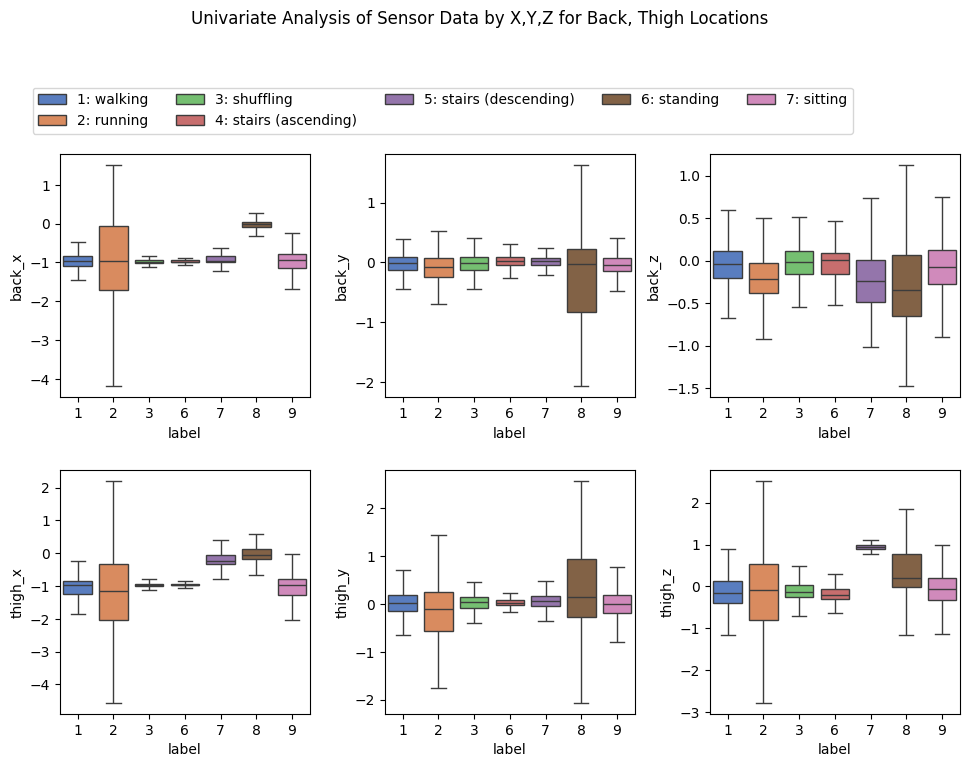

In [ ]:
# Box Plots of sensor data by X,Y,Z for back, thigh locations
fig, axs = plt.subplots(2, 3, figsize=(10, 8))
fig.suptitle('Univariate Analysis of Sensor Data by X,Y,Z for Back, Thigh Locations')
for i, ax in enumerate(axs.flatten()):
    sns.boxplot(x='label', y=features[i], data=df, showfliers=False, palette='muted', hue='label', legend=False, ax=ax)
    # ax.set_title(titles[i])
    ax.set_xticks(list(range(0, value_counts.size)))
fig.subplots_adjust(left=0.08, right=0.98, top=0.8, bottom=0.1, wspace=0.3, hspace=0.3)
plt.legend([f'{key}: {value}' for key, value in label_map.items()], 
    loc='best',
    bbox_to_anchor=(0.1, 2.1, 0.5, 0.5),
    ncol=5)
plt.show()

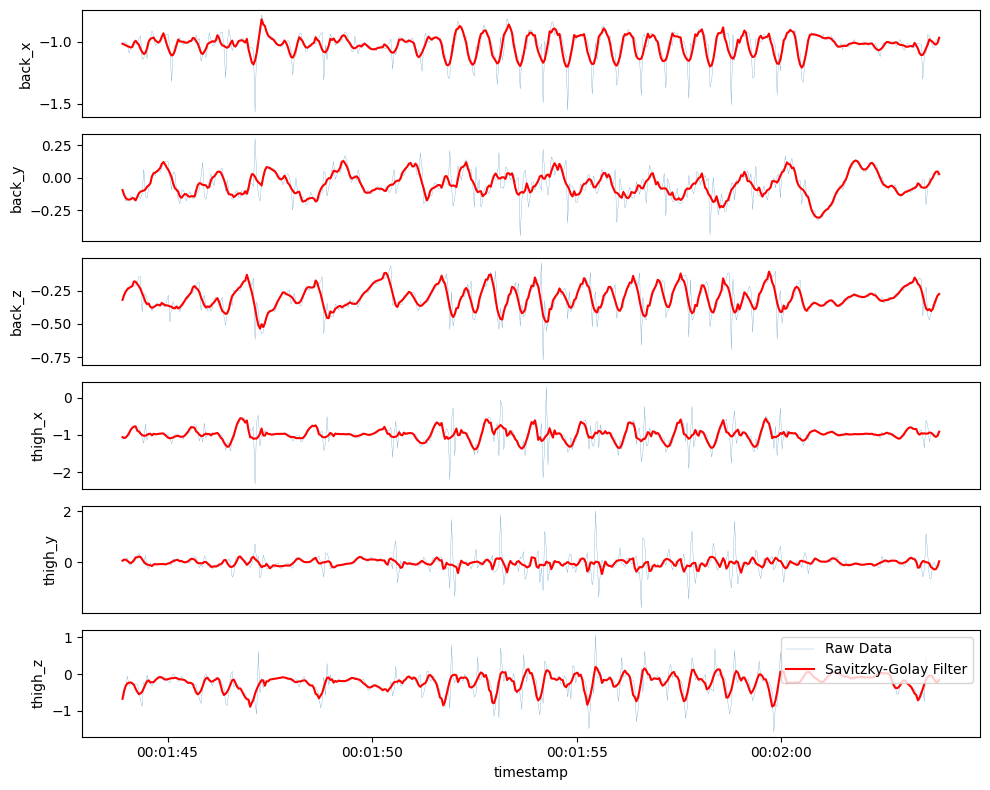

In [ ]:
import scipy.signal as si

# Sample a random subset of the walking data to plot. iloc samples every n rows. head takes the top n rows. 
# Since we want to plot walking data, we need to sample e.g. at a minimum of 10Hz to observe walking movement, rather than sample across hours of walking.
walking_subset = df[(df.label == 1) & (df.file == 'S028')].iloc[::2].head(500)

# walking_subset.to_clipboard()

# plt.plot(walking_subset.index, walking_subset.thigh_z, linewidth=0.2, alpha=0.8, label='Raw Data')
# plt.show()

# # new_labels = [label_map.get(int(label.get_text())) for label in ax.get_xticklabels()]
features = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']

# Use built-in Savitzky-Golay filter for preserving shape while denoising the data.
fig, axs = plt.subplots(6,1, figsize=(10, 8))
for i, ax in enumerate(axs.flatten()):
  sns.lineplot(walking_subset, x=walking_subset.index, y=walking_subset[features[i]], linewidth=0.2, alpha=0.8, label='Raw Data', ax=ax)
  sns.lineplot(walking_subset, x=walking_subset.index, y=si.savgol_filter(walking_subset[features[i]], window_length=10, polyorder=3), label='Savitzky-Golay Filter', ax=ax, color='r')
  # NB x axis labels have to be cleared at the plot level, not the figure level.
  if i == len(features) - 1:
    ax.legend(loc='upper right')
  else:
     ax.set_xticks([])
     ax.set(xlabel=None)
     ax.get_legend().remove()

plt.tight_layout()
plt.show()

In [ ]:
import math
# Write a function that receives the dataset and outputs sliding windows of 2
# seconds size, with an overlap of 1 second (0-2s, 1-3s, 2-4s...etc). Report the
# number of data points with this window size.
def generate_windows(df, sample_rate, window_size, overlap):
    window_count = math.floor(len(df) / (sample_rate * (window_size - overlap)))
    windows = []
    for i in range(window_count):
        windows.append(df.iloc[i:(i+window_size)])
    return window_count, windows

# The sampling rate is 50Hz
count, windows = generate_windows(df, 50, 2, 1)
print(mt.markdown_table([{"Number of data points": count}]).get_markdown())

```
+---------------------+
|Number of data points|
+---------------------+
|        62620        |
+---------------------+```


In [26]:
# Generate an array of feature dictionaries, one per window.
window_features = []
for w in windows:
    # window_features.append({
    #     "back_x_mean": w.back_x.mean(),
    #     "back_y_mean": w.back_y.mean(),
    #     "back_z_mean": w.back_z.mean(),
    #     "thigh_x_mean": w.thigh_x.mean(),
    #     "thigh_y_mean": w.thigh_y.mean(),
    #     "thigh_z_mean": w.thigh_z.mean(),
    #     "back_x_var": w.back_x.var(),
    #     "back_y_var": w.back_y.var(),
    #     "back_z_var": w.back_z.var(),
    #     "thigh_x_var": w.thigh_x.var(),
    #     "thigh_y_var": w.thigh_y.var(),
    #     "thigh_z_var": w.thigh_z.var(),
    # })
    window_features.append([
        w.back_x.mean(),
        w.back_y.mean(),
        w.back_z.mean(),
        w.thigh_x.mean(),
        w.thigh_y.mean(),
        w.thigh_z.mean(),
        w.back_x.var(),
        w.back_y.var(),
        w.back_z.var(),
        w.thigh_x.var(),
        w.thigh_y.var(),
        w.thigh_z.var(),
    ])

# inertias = []

from sklearn.cluster import KMeans

# for i in range(1,11):
#     kmeans = KMeans(n_clusters=i)
#     kmeans.fit(window_features)
#     inertias.append(kmeans.inertia_)

# plt.plot(range(1,11), inertias, marker='o')
# plt.title('Elbow method')
# plt.xlabel('Number of clusters')
# plt.ylabel('Inertia')
# plt.show()

kmeans = KMeans(n_clusters=7)
kmeans.fit(window_features)

kmeans.labels_

/Users/jamescarlyle/phd/comp6246/.venv310/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/jamescarlyle/phd/comp6246/.venv310/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/jamescarlyle/phd/comp6246/.venv310/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/jamescarlyle/phd/comp6246/.venv310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/jamescarlyle/phd/comp6246/.venv310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/jamescarlyle/phd/comp6246/.venv310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237

array([2, 2, 2, ..., 3, 3, 3], shape=(62620,), dtype=int32)

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

